In [1]:
import warnings
warnings.filterwarnings('ignore')

from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import bz2

import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.cluster import KMeans
from scipy.spatial import Voronoi

from sklearn.metrics.pairwise import haversine_distances
from math import radians

from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, cophenet

<h1>Berechnung von Zielklassen</h1>

Die Berechnung von Zielklassen funktioniert in mehreren Schritten:

1. Extraktion der Orte aus Tweet-Trainingsdaten
2. kMeans Clustering der Datenpunkte
3. Voronoirepräsentation der Zielklassen (optional, für visuelle Interpretation)
4. Distanzberechnungen von Zielklassen (plus Scoring Function)
5. Hierarchisches Clustering der Zielklassen

<h2> 1. Extraktion der Orte aus Tweet-Trainingsdaten</h2>

Für die Berechnung von Zielklassen benötigen wir ein Abbild über die räumliche Verteilung von Tweets aus vergangenen Daten. Wir führen dies hier exemplarisch durch die Extraktion von place-annotierten Tweets durch. In der nachfolgenden Methode werden die verfügbaren geo-annotierten Tweets sequentiell durchlaufen und eine Zusammenfassung von beobachteten Place-Tags erstellt. Diese Zusammenfassung hält zum einen den Median der Bounding Boxen der Place Objekte. Zum anderen wird festgehalten, wie oft der entsprechende Ort beobachtet wurde.


In [2]:
def create_place_summary(path):
    unique_places = {}
    
    files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]

    for file in files:
        with bz2.open(file, "rb") as content:
            for line in content:
                try:
                    tweet = json.loads(line)
                    place = tweet.get("place")

                    if place is not None:
                        pid = place.get("id")
                        
                        if pid not in unique_places:
                            center = list(zip(*place.get("bounding_box").get("coordinates")[0]))
                            center[0] = sum(center[0]) / len(center[0])
                            center[1] = sum(center[1]) / len(center[1])

                            unique_places[pid] = {"coordinates": center,
                                                 "counts": 1}
                        else:
                            unique_places[pid]["counts"] += 1
                except:
                    # print(traceback.format_exc())
                    pass
    
    sorted_places = sorted([(v["counts"], v["coordinates"]) for v in unique_places.values()], reverse=True)
    return sorted_places

Wir können nun die Methode durch Übergabe des Orderpfades aufrufen.

Eine beispielhafte Ausgabe, wie die Datenstruktur aussieht, ist beigefügt...

In [3]:
path = "./data/geotagged/"

sorted_places = create_place_summary(path)
sorted_places[:10]

[(1916, [-43.4415779, -22.9114217]),
 (939, [-118.4119065, 34.0207895]),
 (634, [-46.5955455, -23.682803]),
 (418, [-95.44648649999999, 29.8384948]),
 (385, [-73.9685415, 40.780709]),
 (370, [-83.1738665, 32.6782075]),
 (331, [-83.804475, 27.698681999999998]),
 (302, [-87.732013, 41.833584450000004]),
 (294, [-73.9487755, 40.655138]),
 (268, [-74.2436709985792, 4.262283502812155])]

Wir wollen uns nun eine visuelle Interpretation der Datenpunkte (zunächst noch ohne Gewichtung) verschaffen. Insbesondere wird deutlich, dass die Koordinaten in der Form Breitengrad/Längengrad abgebildet sind. Dies bestätigt auch ein kurzer Scatterplot:

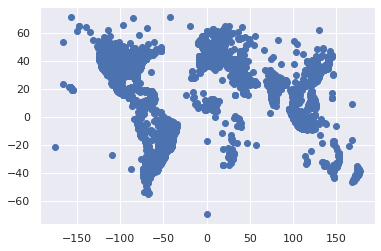

In [4]:
tmp = [(x[0],x[1]) for (_,x) in sorted_places]
x,y = zip(*tmp)
plt.scatter(x,y)

Alternativ ist das im Projekt verwendete File von Places beigefügt. Da hier mehr Informationen verfügbar sind, wird ab sofort mit diesem weitergearbeitet. Prinzipiell funktionieren aber beide Varianten. 

Wie gleich auch ersichtlich, sind Orte hier in Tripeln der Form (Breitengrad, Längengrad, Count) angegeben.

In [5]:
coordinates_list = pickle.load(open("place_summary.pcl", "rb"))
coordinates_list[:10]

[(-43.4415779, -22.9114217, 63615649),
 (-53.18483400000001, -14.239565299999999, 53020376),
 (-46.5955455, -23.682803, 37748840),
 (29.0052228, 41.0213205, 36553014),
 (-95.44648649999999, 29.8384948, 26582018),
 (-118.4119065, 34.0207895, 26127893),
 (-100.0768885, 31.168893500000003, 25997161),
 (-51.1593094, -30.09983615, 24446583),
 (-60.029847999999994, -37.1475765, 23136595),
 (31.18144605, 48.382929000000004, 22209002)]

**Vorverarbeitung der Place Liste**

Damit das Fitting des Clusterings etwas schneller funktioniert, sollen die gesammelten Place-Objekte ausgedünnt werden. Gleichzeitig wird die Datenstruktur so konvertiert, dass sie für den kMeans Algorithmus von sklearn genutzt werden kann, vgl. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Zur Ausdünnung beschränken wir uns hier exemplarisch auf diejenigen Places, die häufiger als 1000 Vorkommen besitzen (vgl. count-Werte). Dazu wird wie folgt vorgegangen:
1. Die Datenpunkte der coordinates_list werden kategorisch gruppiert, so dass drei neue Listen entstehen:
 - $x$: alle Breitengrad-Koordinaten
 - $y$: alle Längengrad-Koordinaten
 - $w$: alle Counts (=Gewichte)
2. Längen- und Breitengrade werden (in dieser Reihenfolge) in ein 2-dim Array $X$ zusammengefügt, welches der primäre Input für den Clusteringalgorithmus ist.
3. Das Array wird auf die häufigsten Zeilen begrenzt. Das geht bspw. über eine np.where Abfrage, eine for-loop über die Gewichte oder alternativ, wie hier gezeigt, über np.bincount. Da die Datenpunkte bereits nach absteigender Häufigkeit sortiert waren, bleiben somit die häufigsten Orte erhalten.

In [6]:
# kategorische Gruppierung
tmp = list(zip(*coordinates_list))

# Zuweisung der drei Listen
w = list(tmp[2])
x = list(tmp[0])
y = list(tmp[1])

# 2d-Repräsentation der Orte
coordinates_list = list(zip(y, x))
X = np.asarray(coordinates_list)

# Ausdünnung
prune_idx = len(coordinates_list) - np.sum(np.bincount(w)[:1000])
print(prune_idx)
X = X[:prune_idx]
w = w[:prune_idx]

62175


<h2> 2. kMeans Clustering der Datenpunkte</h2>

Die Berechnung des kMeans Clusterings erfordert sowohl die Koordinatenmatrix $X$, als auch die Gewichte $w$ als Eingabeparameter.

**In jedem Fall müssen die Ergebnisse des kMeans Algorithmus persistiert werden, da diese später bei der Extraktion von Labels und der Konvertierung von Geocodes benötigt werden.**


Für den explorativer Ansatz wird ein Wertebereich von $k \in [50,300]$ getestet:

100%|██████████| 6/6 [01:11<00:00, 11.90s/it]


Text(0.5, 0, 'Number of Clusters')

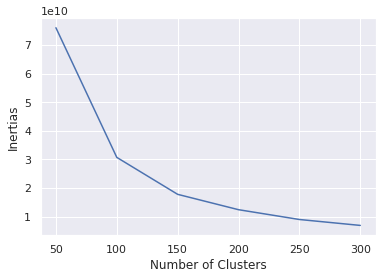

In [7]:
n_clusters = np.arange(50, 301, 50)
inertias = []

for k in tqdm(n_clusters):
    c = KMeans(n_clusters=k, n_jobs=-1).fit(X, sample_weight=w)
    inertias.append(c.inertia_)

plt.plot(n_clusters, inertias)
plt.ylabel("Inertias")
plt.xlabel("Number of Clusters")

In [8]:
kmeans = KMeans(n_clusters=150, n_jobs=-1).fit(X, sample_weight=w)
pickle.dump(kmeans, open("kmeans_150.pcl", "wb"))

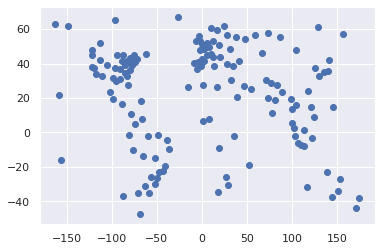

In [9]:
tmp = list(zip(*kmeans.cluster_centers_))

x = tmp[0]
y = tmp[1]
plt.scatter(y, x)

Hier zum Vergleich ein identisches Clustering ohne Gewichtung der Datenpunkte. Der primäre Unterschied besteht darin, dass das gewichtete Clustering eine feinere Unterteilung an den Stellen der Welt macht, an denen sowieso schon sehr viele Datenpunkte vorhanden sind, wo hingegen das normale Clustering alle Datenpunkte als gleichwertig betrachtet und somit räumlich besser verteilte, jedoch unausgewogenere Zielklassen entstehen.

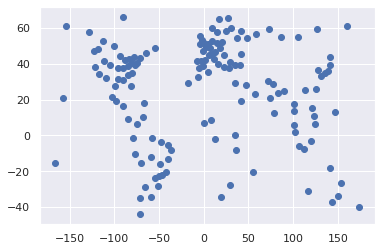

In [10]:
c = KMeans(n_clusters=150, n_jobs=-1).fit(X)
tmp = list(zip(*c.cluster_centers_))

x = tmp[0]
y = tmp[1]
plt.scatter(y, x)

<h2> 3. Voronoirepräsentation der Zielklassen (optional)</h2>

Zeichne eine visuelle Repräsentation der Weltpolygone. 

Die Startpunkte für das Voronoidiagramm sind die Clusterzentren des kMeans-Algorithmus. Diese können dem scipy.spatial.Voronoi Algorithmus übergeben werden. Die daraus resultierenden Voronoi Polygone können jedoch nicht direkt auf der Weltkarte geplottet werden, da einige der Trennlinien außerhalb der maximal zulässigen Weltkoordinaten von $(\pm180, \pm90)$ liegen. Daher werden die betroffenen Kanten mittels einer Hilfsfunktion zunächst diskretisiert und danach auf die soeben genannte Begrenzung projiziert.

In [11]:
centroids = kmeans.cluster_centers_
a, b = np.max(centroids, axis=0)
if b > a:
    centroids[:, [1, 0]] = centroids[:, [0, 1]]  

In [12]:
# Source: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [13]:
# compute (possibly non finite) voronoi regions
vor = Voronoi(centroids)

# use helper method to convert to finite regions (may still be out of bounds)
regions, vertices = voronoi_finite_polygons_2d(vor)

(-90.0, 90.0)

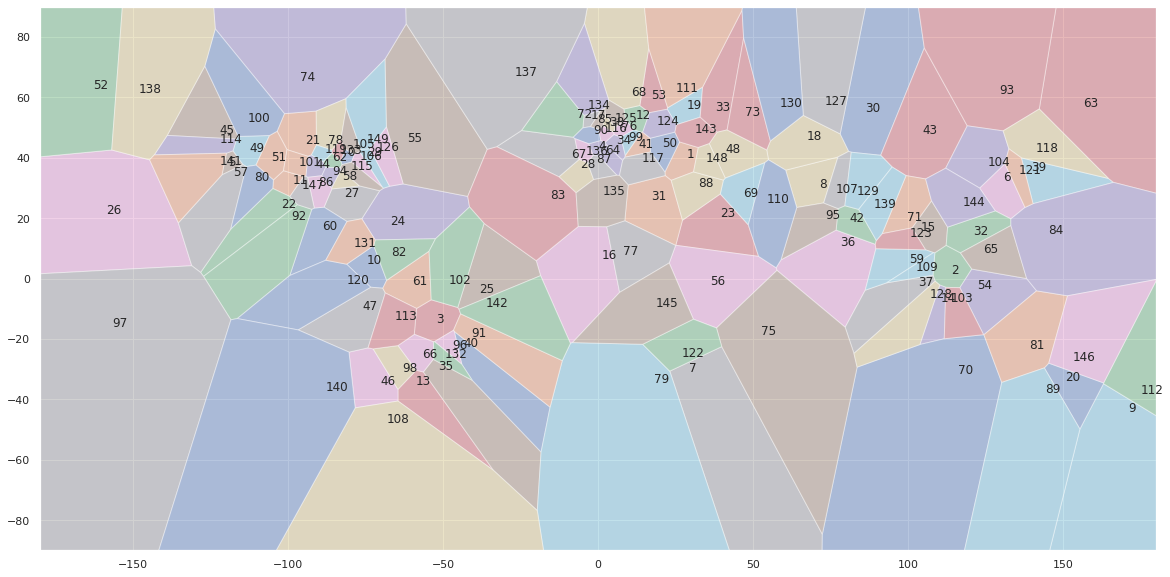

In [14]:
d = {}

plt.figure(figsize=(20, 10))
# Plot (out of bounds) regions and crop the plot
for i, region in enumerate(regions):
    polygon = vertices[region]
    plt.fill(*zip(*np.asarray(polygon)), alpha=0.4)  # draw voronoi regions
    p = np.mean(polygon, axis=0)
    d[i] = {}
    d[i]["bounding_box"] = polygon.tolist()

for i, centroid in enumerate(centroids):
    d[i]["center"] = centroid.tolist()

    plt.text(centroid[0], centroid[1], i) # plot centroid points
    
# crop plot to match world borders
plt.xlim(-180, 180) 
plt.ylim(-90, 90)

<h2> 4. Distanzberechnungen von Zielklassen (plus Scoring Function) </h2>

Distanzberechnungen auf der Erdkugel werden mit der Haversine Distanz durchgeführt. Sowohl für das hierarchische Clustering, als auch für die Scoring Funktion benötigt man eine auf dieser Metrik basierende Distanzmatrix $D$. Für $150$ Zielklassen ist also $D: \mathbb{R}^{150x150}$. Wichtig für die Berechnung der Distanzmatrix ist, dass die Koordinatenpaare als Radianten angegeben sind.

In [15]:
# Koordinaten als Deg
centers = kmeans.cluster_centers_

# Konvertierung zu Rad
centers_rad = [np.asarray([radians(x[0]), radians(x[1])]) for x in centers]

# Berechnung der Distanzmatrix D
R_EARTH = 6371
D = haversine_distances(centers_rad) * R_EARTH  # multipliziere mit r, da ansonsten Distanzen auf Einheitskreis gegeben sind
print(D.shape)
D

(150, 150)


array([[    0.        , 12180.2879621 , 18030.79506041, ...,
         1617.54937553, 12859.17536958,   700.81895797],
       [12180.2879621 ,     0.        ,  9007.40947214, ...,
        13794.29808521,   687.37531988, 11492.12275975],
       [18030.79506041,  9007.40947214,     0.        , ...,
        16786.23120807,  8379.19315499, 18191.16326174],
       ...,
       [ 1617.54937553, 13794.29808521, 16786.23120807, ...,
            0.        , 14474.89360107,  2302.23285178],
       [12859.17536958,   687.37531988,  8379.19315499, ...,
        14474.89360107,     0.        , 12173.31265305],
       [  700.81895797, 11492.12275975, 18191.16326174, ...,
         2302.23285178, 12173.31265305,     0.        ]])

Zur Berechnung der Linkage-Matrix des hierarchischen Clusterings muss die Distanzmatrix als condensed distance matrix dargestellt werden. Der Unterschied besteht darin, dass die Hauptdiagonale der Distanzmatrix fehlt (da sowieso immer 0) und alle anderen Einträge als 1-d Array dargestellt werden und nicht  mehr in 2-d.

In [16]:
# or, as condensed distance matrix D_c
D_c = np.triu(D).ravel()
D_c = D_c[D_c != 0]
D_c

array([12180.2879621 , 18030.79506041,  3720.60302025, ...,
       14474.89360107,  2302.23285178, 12173.31265305])

**Berechnung der Scoring Function**

Wir interpretieren die zwei Dimensionen der Distanzmatrix $D$ bisher als Distanz von Dim 1 nach Dim 2. Anstatt der Distanz soll nun ein auf $1$ normierter und zunächst linear skalierender Wert abgebildet werden. $1$ stellt dann die größte Distanz dar, $0$ ist wieder die Distanz von einer Zielklasse zu sich selbst.

In [17]:
D_ = []
for i in range(D.shape[0]):
    D_.append(D[i] / np.max(D[i]))

D_ = np.vstack(D_)
D_

array([[0.        , 0.62053346, 0.91859171, ..., 0.08240721, 0.65511986,
        0.03570372],
       [0.676914  , 0.        , 0.50058271, ..., 0.76661189, 0.03820057,
        0.63866953],
       [0.91382106, 0.45650569, 0.        , ..., 0.85074516, 0.42466697,
        0.9219487 ],
       ...,
       [0.08127385, 0.69309523, 0.84342506, ..., 0.        , 0.72729179,
        0.11567581],
       [0.71979843, 0.03847616, 0.46902931, ..., 0.81023903, 0.        ,
        0.68140694],
       [0.03521161, 0.57740467, 0.91398802, ..., 0.11567228, 0.61163004,
        0.        ]])

Nun führen wir noch eine exponentielle Skalierung ein, damit falsch klassifizierte Datenpunkte geringfügig teurer, d.h. schlechter eingestuft werden, als davor. Gleichzeitig negieren wir die Interpretation des Wertes. Ein Score von $1$ ist nun optimal, also nur für gleiche Zielklassen erreichbar (vgl. Hauptdiagonale). Dieser Wert nimmt bei weiterer Entfernung bis auf einen Wert von $0$ ab.

In [18]:
D_ = np.vstack(D_)

D_ = 1 - (D_**(2/3))
pickle.dump(D_, open("custom_scores.pcl", "wb"))
D_

array([[1.        , 0.27248246, 0.05503654, ..., 0.81063046, 0.24569467,
        0.89157178],
       [0.22905689, 1.        , 0.36955012, ..., 0.16237358, 0.88657383,
        0.25837539],
       [0.05831112, 0.40712365, 1.        , ..., 0.10215854, 0.43502098,
        0.0527357 ],
       ...,
       [0.81237074, 0.21681937, 0.10731617, ..., 1.        , 0.19126584,
        0.76259217],
       [0.1968304 , 0.88602897, 0.39632945, ..., 0.13088862, 1.        ,
        0.22564929],
       [0.89257041, 0.30659518, 0.05819642, ..., 0.76259701, 0.27945816,
        1.        ]])

Wir können vorherige Visualisierung nun dazu verwenden, dass wir die Scores exemplarisch auf der Weltkarte einzeichen.

(-90.0, 90.0)

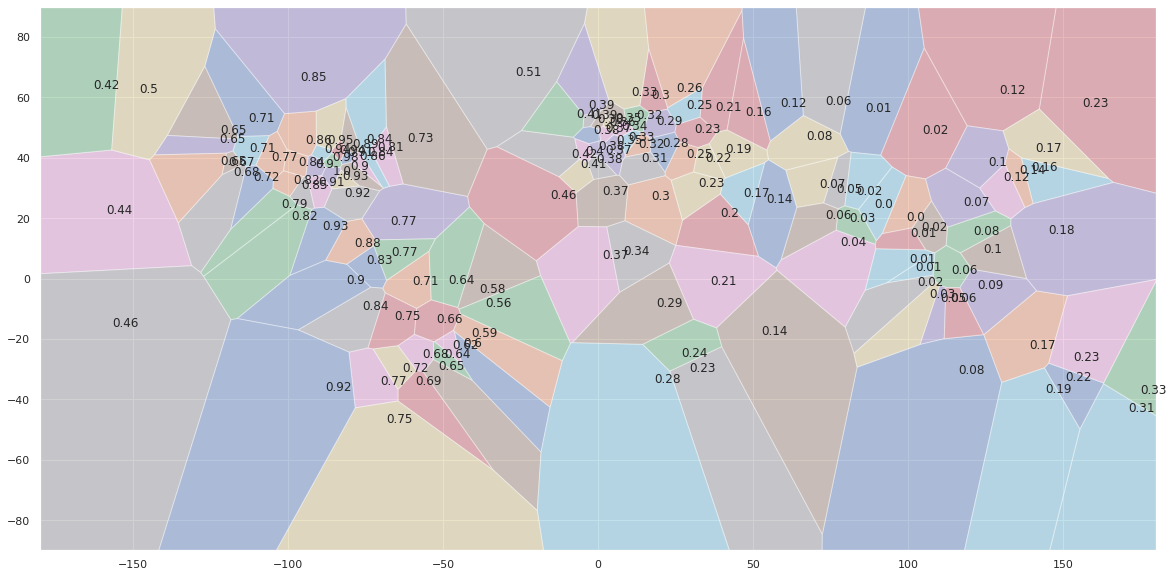

In [19]:
d = {}

plt.figure(figsize=(20, 10))
# Plot (out of bounds) regions and crop the plot
for i, region in enumerate(regions):
    polygon = vertices[region]
    plt.fill(*zip(*np.asarray(polygon)), alpha=0.4)  # draw voronoi regions
    p = np.mean(polygon, axis=0)
    d[i] = {}
    d[i]["bounding_box"] = polygon.tolist()

# Scores von diesem Cluster aus anzeigen
from_cluster_id = np.random.randint(0, 150)
    
for i, cluster in enumerate(kmeans.cluster_centers_):
    plt.text(cluster[0], cluster[1], round(D_[from_cluster_id][i], 2))  # plot centroid points

    
# crop plot to match world borders
plt.xlim(-180, 180) 
plt.ylim(-90, 90)

In [20]:
kmeans.cluster_centers_

array([[-8.09848424e+01,  4.06276020e+01],
       [ 2.85544868e+01,  3.99233298e+01],
       [ 1.13985999e+02,  1.66516642e+00],
       [-5.21122997e+01, -1.46571406e+01],
       [ 3.55480093e-02,  4.26536978e+01],
       [-1.19282325e+02,  3.73604803e+01],
       [ 1.30616422e+02,  3.25882443e+01],
       [ 2.94899304e+01, -3.07516536e+01],
       [ 7.14271469e+01,  3.01655936e+01],
       [ 1.71151160e+02, -4.41633581e+01],
       [-7.46056715e+01,  4.91893038e+00],
       [-9.84445838e+01,  3.15876759e+01],
       [ 1.23185615e+01,  5.31230774e+01],
       [-5.88020222e+01, -3.50413542e+01],
       [ 1.10440527e+02, -7.51117197e+00],
       [ 1.04245444e+02,  1.59559275e+01],
       [ 1.24053469e+00,  6.66499864e+00],
       [-2.21784410e+00,  5.28850814e+01],
       [ 6.73127578e+01,  4.61197896e+01],
       [ 2.85400509e+01,  5.63934353e+01],
       [ 1.50784679e+02, -3.38532486e+01],
       [-9.43711446e+01,  4.46725319e+01],
       [-1.02273139e+02,  2.36560199e+01],
       [ 3.

**Hierarchisches Clustering von Zielklassen**

Für das agglomerative Clustering werden zwei Informationen benötigt: erstens die gewünschte Linkage-Funktion und zweitens die gewünschte Distanzfunktion. Anstatt die Distanzen erneut zu berechnen, kann auch die bereits existierende CDM (condensed distance matrix) übergeben werden. 

Welche Linkagefunktion verwendet werden sollte, ist abhängig vom Datensatz. Wir testen hier die gängigsten und etabliertesten Verfahren und überprüfen, wie gut ein Clustering mit dieser Fusionsstrategie die ursprünglichen Inter-Cluster-Distanzen erhält (Cophenet)

In [21]:
# find best linkage metric
linkage_results = []

for link in ["ward", "single", "complete", "average", "weighted"]:
    Z = linkage(D_c, link)
    c, _ = cophenet(Z, D_c)
    linkage_results.append((link, c))
linkage_results = sorted(linkage_results, key=lambda x: x[1], reverse=True)

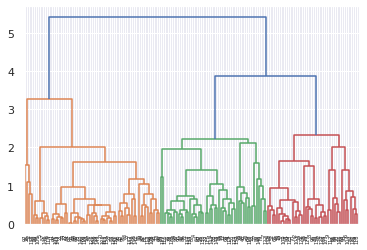

In [22]:
# Agglomeratives Clustering mit bester Linkage Metrik
Z = linkage(D_, linkage_results[0][0])
dn = dendrogram(Z)

# in Baumstruktur abspeichern
root = to_tree(Z)
pickle.dump(root, open("place_hierarchy.pcl", "wb"))